In [1]:

import sys
import os.path
!pip install mplhep

!pip install atlasopenmagic
from atlasopenmagic import install_from_environment
install_from_environment()

Installing packages: ['aiohttp>=3.9.5', 'atlasopenmagic>=1.0.1', 'awkward>=2.6.7', 'awkward-pandas>=2023.8.0', 'coffea~=0.7.0', 'hist>=2.8.0', 'ipykernel>=6.29.5', 'jupyter>=1.0.0', 'lmfit>=1.3.2', 'matplotlib>=3.9.1', 'metakernel>=0.30.2', 'notebook<7', 'numpy>=1.26.4', 'pandas>=2.2.2', 'papermill>=2.6.0', 'pip>=24.2', 'scikit-learn>=1.5.1', 'uproot>=5.3.10', 'uproot3>=3.14.4', 'fsspec-xrootd>=0.5.1', 'jupyterlab_latex~=3.1.0', 'vector>=1.4.1']
Installation complete. You may need to restart your Python environment for changes to take effect.


In [1]:
import numpy as np # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
import matplotlib_inline # to edit the inline plot format
#matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg') # to make plots in pdf (vector) format
from matplotlib.ticker import AutoMinorLocator # for minor ticks
import uproot # for reading .root files
import vector # for 4-momentum calculations
import time # for printing time stamps
import requests # for file gathering, if needed

MeV = 0.001
GeV = 1.0

In [2]:
import atlasopenmagic as atom
atom.available_releases()
atom.set_release('2025e-13tev-beta')

Available releases:
2016e-8tev        2016 Open Data for education release of 8 TeV proton-proton collisions (https://opendata.cern.ch/record/3860).
2020e-13tev       2020 Open Data for education release of 13 TeV proton-proton collisions (https://cern.ch/2r7xt).
2024r-pp          2024 Open Data for research release for proton-proton collisions (https://opendata.cern.record/80020).
2024r-hi          2024 Open Data for research release for heavy-ion collisions (https://opendata.cern.ch/record/80035).
2025e-13tev-beta  2025 Open Data for education and outreach beta release for 13 TeV proton-proton collisions (https://opendata.cern.ch/record/93910).
2025r-evgen       2025 Open Data for research release for event generation (https://opendata.cern.ch/record/160000).
Active release set to: 2025e-13tev-beta. Metadata cache cleared.


In [3]:
lumi = 36.6 # fb-1 # data size of the full release
fraction = 1.0 # reduce this is if you want the code to run quicker

In [4]:
# Select the skim to use for the analysis
skim = "2bjets"

In [5]:
mc_defs = {
    r'Background $t\bar{t}$':{'dids': [410470], 'color': "#6b59d3" }, # purple
    r'Signal ($m_H$ = 125 GeV)':  {'dids': [345949],'color': "#00cdff" },# light blue
}

mc_samples   = atom.build_mc_dataset(mc_defs, skim=skim, protocol='https')
data_samples = atom.build_data_dataset(skim, protocol='https')

samples = {**data_samples, **mc_samples}

Fetching and caching all metadata for release: 2025e-13tev-beta...
Successfully cached 374 datasets.


In [6]:
samples.keys()

dict_keys(['Data', 'Background $t\\bar{t}$', 'Signal ($m_H$ = 125 GeV)'])

In [7]:
# We shall use the first entry in 'list', 'data15_periodD'
value = samples['Data']['list'][0]
print(f"{value = }")

# This is now appended to our file path to retrieve the data_A.4lep.root file
data15_periodD = value #path + "Data/" + value + ".root"

value = 'https://opendata.cern.ch/eos/opendata/atlas/rucio/user/egramsta/data15_periodD.2bjets70.root'


In [8]:
# Accessing the file from the online database (":analysis" opens the tree in a desired manner)
tree = uproot.open(data15_periodD + ":analysis")

# There are 39 entries in the tree
print(tree.num_entries)

# We can view all the information stored in the tree using the .keys() method.
print(tree.keys())

# We can also view the entire tree using the .arrays() method
# This generates a 39-entry list of dictionaries
print(tree.arrays())

424678
['num_events', 'sum_of_weights', 'sum_of_weights_squared', 'category', 'sig_lep', 'sig_muo', 'sig_ele', 'sig_pho', 'sig_jet', 'sig_bjet70', 'n_lep', 'n_ele', 'n_muo', 'n_jet', 'n_pho', 'n_bjet70', 'TriggerMatch_DILEPTON', 'ScaleFactor_MLTRIGGER', 'ScaleFactor_PILEUP', 'ScaleFactor_FTAG', 'mcWeight', 'xsec', 'filteff', 'kfac', 'channelNumber', 'eventNumber', 'runNumber', 'trigML', 'trigP', 'trigDT', 'trigT', 'trigE', 'trigDM', 'trigDE', 'trigM', 'trigMET', 'ScaleFactor_BTAG', 'ScaleFactor_JVT', 'jet_n', 'jet_pt', 'jet_eta', 'jet_phi', 'jet_e', 'jet_btag_quantile', 'jet_jvt', 'largeRJet_n', 'largeRJet_pt', 'largeRJet_eta', 'largeRJet_phi', 'largeRJet_e', 'largeRJet_m', 'largeRJet_D2', 'jet_pt_jer1', 'jet_pt_jer2', 'ScaleFactor_ELE', 'ScaleFactor_MUON', 'ScaleFactor_LepTRIGGER', 'ScaleFactor_MuTRIGGER', 'ScaleFactor_ElTRIGGER', 'lep_n', 'lep_type', 'lep_pt', 'lep_eta', 'lep_phi', 'lep_e', 'lep_charge', 'lep_ptvarcone30', 'lep_topoetcone20', 'lep_z0', 'lep_d0', 'lep_d0sig', 'lep_isT

In [9]:
import pandas as pd

arrays = tree.arrays(['num_events', 'sum_of_weights', 'sum_of_weights_squared', 'category', 'sig_lep', 'sig_muo', 'sig_ele', 'sig_pho', 'sig_jet', 'sig_bjet70', 'n_lep', 'n_ele', 'n_muo', 'n_jet', 'n_pho', 'n_bjet70', 'TriggerMatch_DILEPTON', 'ScaleFactor_MLTRIGGER', 'ScaleFactor_PILEUP', 'ScaleFactor_FTAG', 'mcWeight', 'xsec', 'filteff', 'kfac', 'channelNumber', 'eventNumber', 'runNumber', 'trigML', 'trigP', 'trigDT', 'trigT', 'trigE', 'trigDM', 'trigDE', 'trigM', 'trigMET', 'ScaleFactor_BTAG', 'ScaleFactor_JVT', 'jet_n', 'jet_pt', 'jet_eta', 'jet_phi', 'jet_e', 'jet_btag_quantile', 'jet_jvt', 'largeRJet_n', 'largeRJet_pt', 'largeRJet_eta', 'largeRJet_phi', 'largeRJet_e', 'largeRJet_m', 'largeRJet_D2', 'jet_pt_jer1', 'jet_pt_jer2', 'ScaleFactor_ELE', 'ScaleFactor_MUON', 'ScaleFactor_LepTRIGGER', 'ScaleFactor_MuTRIGGER', 'ScaleFactor_ElTRIGGER', 'lep_n', 'lep_type', 'lep_pt', 'lep_eta', 'lep_phi', 'lep_e', 'lep_charge', 'lep_ptvarcone30', 'lep_topoetcone20', 'lep_z0', 'lep_d0', 'lep_d0sig', 'lep_isTightID', 'lep_isMediumID', 'lep_isLooseID', 'lep_isTightIso', 'lep_isLooseIso', 'lep_isTrigMatched', 'ScaleFactor_PHOTON', 'photon_n', 'photon_pt', 'photon_eta', 'photon_phi', 'photon_e', 'photon_ptcone20', 'photon_topoetcone40', 'photon_isLooseID', 'photon_isTightID', 'photon_isLooseIso', 'photon_isTightIso', 'ScaleFactor_TAU', 'ScaleFactor_TauTRIGGER', 'ScaleFactor_DiTauTRIGGER', 'tau_n', 'tau_pt', 'tau_eta', 'tau_phi', 'tau_e', 'tau_charge', 'tau_nTracks', 'tau_isTight', 'tau_RNNJetScore', 'tau_RNNEleScore', 'truth_jet_n', 'truth_jet_pt', 'truth_jet_eta', 'truth_jet_phi', 'truth_jet_m', 'truth_elec_n', 'truth_elec_pt', 'truth_elec_eta', 'truth_elec_phi', 'truth_muon_n', 'truth_muon_pt', 'truth_muon_eta', 'truth_muon_phi', 'truth_tau_n', 'truth_tau_pt', 'truth_tau_eta', 'truth_tau_phi', 'truth_photon_n', 'truth_photon_pt', 'truth_photon_eta', 'truth_photon_phi', 'truth_met', 'truth_met_phi', 'met', 'met_phi', 'met_mpx', 'met_mpy'], library="np")
df = pd.DataFrame(arrays)

In [10]:
df

,num_events,sum_of_weights,sum_of_weights_squared,category,sig_lep,sig_muo,sig_ele,sig_pho,sig_jet,sig_bjet70,...,truth_photon_n,truth_photon_pt,truth_photon_eta,truth_photon_phi,truth_met,truth_met_phi,met,met_phi,met_mpx,met_mpy
0,1.0,1.0,1.0,data15,[],[],[],[],"[1, 1]","[1, 1]",...,0,[],[],[],0.0,0.0,27.754730,-1.554974,0.439135,-27.751255
1,1.0,1.0,1.0,data15,[],[],[],[],"[1, 1, 1, 1]","[1, 0, 1, 0]",...,0,[],[],[],0.0,0.0,32.688263,1.681554,-3.613086,32.487968
2,1.0,1.0,1.0,data15,[],[],[],[],"[1, 1, 1]","[0, 1, 1]",...,0,[],[],[],0.0,0.0,37.918331,0.864772,24.601921,28.853863
3,1.0,1.0,1.0,data15,[],[],[],[1],"[1, 1, 1, 1]","[1, 0, 1, 0]",...,0,[],[],[],0.0,0.0,29.825333,-3.008784,-29.562687,-3.949428
4,1.0,1.0,1.0,data15,[],[],[],[],"[1, 1]","[1, 1]",...,0,[],[],[],0.0,0.0,26.327034,-0.468861,23.485910,-11.896416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424673,1.0,1.0,1.0,data15,[],[],[],[],"[1, 1]","[1, 1]",...,0,[],[],[],0.0,0.0,12.900966,-1.877632,-3.896657,-12.298414
424674,1.0,1.0,1.0,data15,[],[],[],[],"[1, 1, 1, 1, 1]","[0, 1, 1, 0, 0]",...,0,[],[],[],0.0,0.0,41.035423,-1.555693,0.619736,-41.030743
424675,1.0,1.0,1.0,data15,[],[],[],[],"[1, 1]","[1, 1]",...,0,[],[],[],0.0,0.0,45.468639,2.262348,-28.996859,35.022556
424676,1.0,1.0,1.0,data15,[],[],[],[],"[1, 1, 1, 1]","[1, 0, 1, 0]",...,0,[],[],[],0.0,0.0,50.234741,-3.072332,-50.114300,-3.476490


In [11]:
df_cut = df[df["jet_pt"].apply(lambda x: len(x) >= 2)]
df_cut = df_cut[
    (df_cut["jet_pt"].apply(lambda x: x[0] > 40 and x[1] > 30)) &
    (df_cut["jet_eta"].apply(lambda x: abs(x[0]) < 2.5 and abs(x[1]) < 2.5))
]


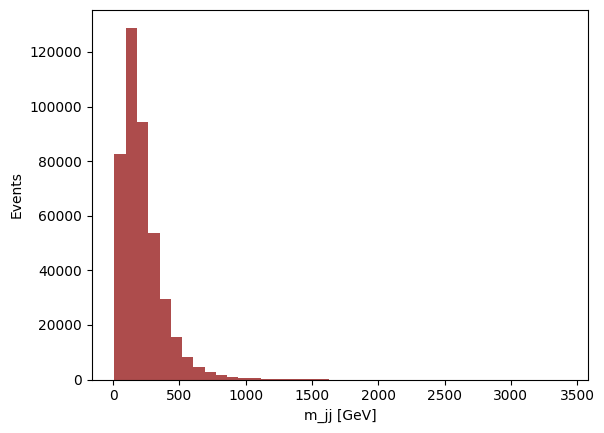

In [12]:
def invariant_mass(row):
    E1, E2 = row["jet_e"][0], row["jet_e"][1]
    pt1, pt2 = row["jet_pt"][0], row["jet_pt"][1]
    eta1, eta2 = row["jet_eta"][0], row["jet_eta"][1]
    phi1, phi2 = row["jet_phi"][0], row["jet_phi"][1]

    px1, px2 = pt1 * np.cos(phi1), pt2 * np.cos(phi2)
    py1, py2 = pt1 * np.sin(phi1), pt2 * np.sin(phi2)
    pz1, pz2 = pt1 * np.sinh(eta1), pt2 * np.sinh(eta2)

    E = E1 + E2
    px = px1 + px2
    py = py1 + py2
    pz = pz1 + pz2

    m2 = E**2 - (px**2 + py**2 + pz**2)
    return np.sqrt(m2) if m2 > 0 else 0

df["mjj"] = df[df["jet_e"].apply(len) >= 2].apply(invariant_mass, axis=1)
df_cut["mjj"] = df_cut.apply(invariant_mass, axis=1)

# Tracé
import matplotlib.pyplot as plt
plt.hist(df["mjj"].dropna(), bins=40, color='darkred', alpha=0.7)
plt.xlabel("m_jj [GeV]")
plt.ylabel("Events")
plt.title("")
#plt.grid()
plt.show()

In [13]:
plt.style.use(mplhep.style.ATLAS)
plt.hist(df_cut["mjj"], bins=40, histtype='stepfilled', color='darkred', alpha=0.7, label="Signal")

mplhep.atlas.label(text="ATLAS Open Data", loc=1)

plt.xlabel(r"$m_{jj}$ [GeV]")
plt.ylabel("Events")
plt.legend()
plt.grid(True)


NameError: name 'mplhep' is not defined